# Ch 0. Python與機器學習
## 0-4. 基礎數學與Python實作
[0-4-4. 統計推論](#sec0_4_4)
***

<a id='sec0_4_4'></a>
### 0-4-4. 統計推論

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

# 對一個物品秤重十次得到的結果
物品 = [10.1, 10, 9.8, 10.5, 9.7, 10.1, 9.9, 10.2, 10.3, 9.9]

# 進行區間估計
# np.mean(物品) -> 樣本均值
# stats.sem(物品) -> 樣本均值的標準誤(Standard Error)
# 樣本均值服從 t 分佈，用標準誤來表示樣本均值的標準差
# 自由度為 len(物品)-1，信心水準為 95%
conf_in = stats.t.interval(alpha = 0.95, 
                           df=len(物品)-1, 
                           loc=np.mean(物品), 
                           scale=stats.sem(物品))
print('信賴區間 =', conf_in)

信賴區間 = (9.877224892797548, 10.222775107202454)


In [2]:
def normal_cdf(x, mu=0,sigma=1):
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z, low_p = -10.0, 0            # normal_cdf(-10) is (very close to) 0
    hi_z,  hi_p  =  10.0, 1            # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the cdf's value there
        if mid_p < p:
            # midpoint is still too low, search above it
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # midpoint is still too high, search below it
            hi_z, hi_p = mid_z, mid_p
        else:
            break

    return mid_z

def normal_upper_bound(probability, mu=0, sigma=1):
    """Returns the z for which P(Z <= z) = probability"""
    return inverse_normal_cdf(probability, mu, sigma)

def normal_lower_bound(probability, mu=0, sigma=1):
    """Returns the z for which P(Z >= z) = probability"""
    return inverse_normal_cdf(1 - probability, mu, sigma)

def normal_two_sided_bounds(probability, mu=0, sigma=1):
    """
    Returns the symmetric (about the mean) bounds
    that contain the specified probability
    """
    tail_probability = (1 - probability) / 2
    # upper bound should have tail_probability above it
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)
    # lower bound should have tail_probability below it
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)

    return lower_bound, upper_bound

In [3]:
# P-hacking
# 欲透過投擲結果檢定一個公正的硬幣是否公正
import random as rd
import math

def 進行實驗():
    # 擲一個公正硬幣 1,000 次，True->正面，False->反面
    return [rd.random() < 0.5 for _ in range(1000)]
    
# 實驗進行 100 回合
實驗 = [進行實驗() for _ in range(100)]

p_val = 0.05
拒絕H0次數 = 0
for trial in 實驗:
    num_heads = len([x for x in trial if x])
    p_hat = num_heads/1000
    
    mu = p_hat
    sigma = math.sqrt(p_hat*(1-p_hat)/1000)
    interval = normal_two_sided_bounds(1-p_val, mu, sigma)
    
    if not (interval[0] < 0.5 < interval[1]):
        拒絕H0次數 += 1

print('拒絕H_0次數 =', 拒絕H0次數)

拒絕H_0次數 = 6


In [4]:
df = pd.read_csv("pokemon_894_12.csv", header=0)

# 卡方獨立性檢定
# 看水與一般屬性的寶可夢，其單/雙屬性數量是否有差別)
# H0:兩者沒差異
df_new = pd.DataFrame(columns=['Water', 'Normal'], index=['單', '雙'])
df_new.loc['單', :] = [df[(df['Type1']=='Water') & (pd.isnull(df['Type2']))].Number.count(), 
                       df[(df['Type1']=='Normal') & (pd.isnull(df['Type2']))].Number.count()]
df_new.loc['雙', :] = [df[(df['Type1']=='Water') & (pd.notnull(df['Type2']))].Number.count(), 
                       df[(df['Type1']=='Normal') & (pd.notnull(df['Type2']))].Number.count()]
df_new

,Water,Normal
單,65,66
雙,57,44


In [5]:
chi2, p_val = stats.chisquare(f_obs=[65, 66],
                              f_exp=[57, 44])
print(chi2)  # 卡方統計量
print(p_val) # p值

12.12280701754386
0.0004980887123686391


以顯著水準為 0.01 來看，p值遠小於顯著水準，\
因此可以拒絕H0，亦即水與一般屬性寶可夢的單/雙屬性數量有非常顯著的差異。

In [6]:
# 看世代與單/雙屬性是否有差別
# H0:兩者沒差異
gens = df['Generation'].unique()
df_new = pd.DataFrame(columns=gens, index=['單', '雙'])

for i in ['單', '雙']:
    lst = []
    for x in gens:
        if i == '單':
            lst.append(df[(df['Generation']==x) & (pd.isnull(df['Type2']))].Number.count())
        else:
            lst.append(df[(df['Generation']==x) & (pd.notnull(df['Type2']))].Number.count())
                    
    df_new.loc[i, :] = lst
                        
df_new

,1,2,3,4,5,6,7
單,88,51,78,54,83,32,35
雙,78,55,82,67,82,50,59


In [7]:
T = np.array(df_new)
chi2, p, dof, ex = stats.chi2_contingency(T, correction=False)
print(chi2) # 卡方統計量
print(dof)  # 自由度
print(p)    # p值

9.341984532800193
6
0.1552388323484806


p值>顯著水準(0.01)，因此不能拒絕H0，亦即寶可夢世代與單/雙屬性無顯著差異。

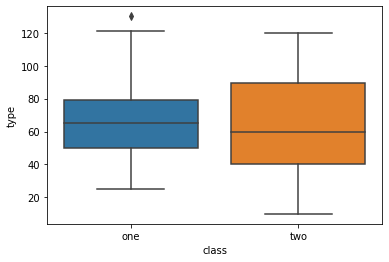

In [8]:
# 想了解 Poison 與 Ground 屬性寶可夢的平均 Speed 是否不同？
# 獨立 t-test 的前提假設: 資料為常態分佈或接近常態分佈，且變異數相同
import seaborn as sns

fea = 'Speed'
one = np.array(df[df['Type1'] == 'Poison'][fea])
two = np.array(df[df['Type1'] == 'Ground'][fea])

data = {'class':['one']*len(one)+['two']*len(two), 'type':np.append(one, two)}
df_new = pd.DataFrame(data)
sns.boxplot(x='class', y='type', data=df_new);

In [9]:
# 檢查資料是否為常態分布 (H0:資料為常態分佈)
# 由於樣本數小於 50，故採用 Shapiro-Wilk test
p_val = stats.shapiro(one)[1]
print('p_value:', p_val)
if p_val < .05:
    print('拒絕H0，Poison 屬性寶可夢非常態分佈')
else:
    print('不拒絕H0，Ground 屬性寶可夢為常態分佈')

p_val = stats.shapiro(two)[1]
print('p_value:', p_val)
if p_val < .05:
    print('拒絕H0，Poison 屬性寶可夢非常態分佈')
else:
    print('不拒絕H0，Ground 屬性寶可夢為常態分佈')

p_value: 0.15207724273204803
不拒絕H0，Ground 屬性寶可夢為常態分佈
p_value: 0.14700447022914886
不拒絕H0，Ground 屬性寶可夢為常態分佈


In [10]:
# 檢查資料是否為相同變異數 (H0:相同變異數)
# 採用 Levene's test
p_val = stats.levene(one, two, center='mean')[1]
print('p_value:', p_val)
if p_val < .05:
    print('拒絕H0，不同變異數')
else:
    print('不拒絕H0，相同變異數')

p_value: 0.2715227383615329
不拒絕H0，相同變異數


In [11]:
# 計算兩組獨立樣本變異數相同 t-test
p_val = stats.ttest_ind(one, two, equal_var=True)[1]
print('p_value:', p_val)
if p_val < .05:
    print('拒絕H0，不同平均值')
else:
    print('不拒絕H0，相同平均值')

p_value: 0.5726416638984138
不拒絕H0，相同平均值
